In [22]:
import pandas as pd
import matplotlib.pyplot as plt

import yfinance as yf
import datetime

from valueinvesting import utils as utils

# 1. Load raw input
## Hardcoded block

In [23]:
evaluate_last_X_years = False
X=10
currency_pair = 'CAD=X'
numbers_in_currency = 'USD'
share_name = 'BTO.TO'

# 1.2. Raw input statement data

In [24]:
route = f"../data/input/{share_name}_data.csv"
data = pd.read_csv(route, sep=';', parse_dates=['date'])
# replace -, extend missing 0-s, fix datatype
data = utils.replace_format_input(data)

In [25]:
owned_shares = pd.read_csv('../data/extras/owned_stocks.csv', sep=';', parse_dates=['date'])
owned_shares = owned_shares.loc[(owned_shares['stock'] == share_name) & (owned_shares['active'] == 'yes')]

## (OPTIONAL) Time Filtering - Last 7 years daat

In [26]:
if evaluate_last_X_years:
    data = data[data['date'] > datetime.datetime.today() - datetime.timedelta(days=X*366+93)]
    data = data.reset_index(drop=True)

data.head()

,date,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,curr_assets,goodwill,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,shares
0,2009-06-30,8,-8,-1,-3,5,3,7,16,0,...,224,0,0,0,16,0,39,-4,-14,282.5
1,2009-09-30,9,-9,1,-2,9,5,8,26,0,...,241,0,0,0,13,0,31,1,8,282.5
2,2009-12-31,4,-5,-1,-17,3,5,10,23,0,...,247,0,1,0,12,9,48,-7,-42,282.5
3,2010-03-31,17,-16,1,-4,22,11,12,47,0,...,283,0,0,15,30,0,58,1,-15,337.6
4,2010-06-30,23,-19,5,-8,14,10,18,44,0,...,285,0,0,17,33,0,60,-1,-9,337.6


## Calculate date when quaterly reports could be available

In [27]:
data = utils.calculate_real_date(data)

# 2. Filter out unnecesary columns

In [28]:
data = utils.filter_raw_data(data)
data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,intangible_assets,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex
54,2022-12-31,2023-02-11,1071.0,592,-332,261,176,652,0,332,...,0,3681,0,0,16,234,13,673,270,-113
55,2023-03-31,2023-04-21,1237.4,474,-260,214,102,674,0,350,...,0,3768,0,0,15,268,11,721,204,-111
56,2023-06-30,2023-07-21,1237.4,471,-281,190,92,506,0,339,...,0,4931,0,0,17,319,15,909,195,-205
57,2023-09-30,2023-10-21,1237.4,478,-307,171,-35,310,0,344,...,0,4852,0,0,15,325,12,895,110,-226
58,2023-12-31,2024-02-11,1237.4,512,-306,206,-117,307,0,346,...,0,4875,0,0,16,313,152,1064,205,-269


## Pull historical average USD national currency rates and add to the dataframe

In [29]:
data['usd_nat_currency'] = utils.daily_price(
    ticker=currency_pair,
    end=data['date'],
    days_earlier=90
    )

# drop rows, when USD rates wasn't available
data = data[data['usd_nat_currency'].notna()]

data.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
54,2022-12-31,2023-02-11,1071.0,592,-332,261,176,652,0,332,...,3681,0,0,16,234,13,673,270,-113,1.357405
55,2023-03-31,2023-04-21,1237.4,474,-260,214,102,674,0,350,...,3768,0,0,15,268,11,721,204,-111,1.352063
56,2023-06-30,2023-07-21,1237.4,471,-281,190,92,506,0,339,...,4931,0,0,17,319,15,909,195,-205,1.343352
57,2023-09-30,2023-10-21,1237.4,478,-307,171,-35,310,0,344,...,4852,0,0,15,325,12,895,110,-226,1.341033
58,2023-12-31,2024-02-11,1237.4,512,-306,206,-117,307,0,346,...,4875,0,0,16,313,152,1064,205,-269,1.361617


## Convert USD values related to IS, BS, CFS to national currency

In [30]:
# convert columns into national currency if necessary
if numbers_in_currency == 'USD':
    data_nat_curr = utils.convert_national_currency(input_data=data, currency=data)
else:
    data_nat_curr = data.copy()
data_nat_curr.tail()

,date,real_date,shares,revenue,cogs,gross_profit,net_profit,cash,acc_rec,inventory,...,total_assets,acc_pay,short_term_debt,current_debt,curr_liab,long_term_debt,total_liab,cash_from_operating_activities,capex,usd_nat_currency
54,2022-12-31,2023-02-11,1071.0,803.583810,-450.658488,354.282727,238.903295,885.028115,0.0,450.658488,...,4996.608117,0.0,0.0,21.718481,317.632790,17.646266,913.533622,366.499373,-153.386775,1.357405
55,2023-03-31,2023-04-21,1237.4,640.877699,-351.536290,289.341408,137.910391,911.290230,0.0,473.221929,...,5094.572086,0.0,0.0,20.280940,362.352792,14.872689,974.837175,275.820782,-150.078955,1.352063
56,2023-06-30,2023-07-21,1237.4,632.718662,-377.481834,255.236827,123.588359,679.735972,0.0,455.396234,...,6624.067349,0.0,0.0,22.836979,428.529200,20.150276,1221.106717,261.953586,-275.387103,1.343352
57,2023-09-30,2023-10-21,1237.4,641.013737,-411.697107,229.316630,-46.936152,415.720206,0.0,461.315326,...,6506.691743,0.0,0.0,20.115494,435.835700,16.092395,1200.224466,147.513622,-303.073441,1.341033
58,2023-12-31,2024-02-11,1237.4,697.148103,-416.654921,280.493182,-159.309235,418.016538,0.0,471.119617,...,6637.884772,0.0,0.0,21.785878,426.186243,206.965843,1448.760902,279.131565,-366.275078,1.361617


# 3. Calculate input to Value Raios (eps, bv per share, fcf)
## filter out unwanted columns

In [31]:
filtered_nat_curr = utils.calculate_input_value_ratios(data_nat_curr)

## Calculate input values to value ratios

In [32]:
ratios_nat_curr = utils.ratios_input_filter(filtered_nat_curr)

In [33]:
ratios_nat_curr = utils.evaluate_performance(input=filtered_nat_curr, output=ratios_nat_curr)

# 4. Pull historical share prices and merge with sattement data

In [34]:
# pull weekly share prices and merge with the value ratios
merged_nat_curr = utils.add_share_prices_to_value_ratios(share_name, data, ratios_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,equity_ratio,debt_ratio,acc_rec_ratio,acc_pay_ratio,cash_turnover,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe
0,2009-07-27,0.617709,2009-06-30,9.338312,-0.049584,0.764419,282.5,46.691562,0.16528,5.836445,...,0.825893,0.174107,10.666667,inf,6.4,4.571429,-0.125,-0.375,-0.053571,-0.064865
1,2009-08-03,0.634633,2009-06-30,9.338312,-0.049584,0.764419,282.5,46.691562,0.16528,5.836445,...,0.825893,0.174107,10.666667,inf,6.4,4.571429,-0.125,-0.375,-0.053571,-0.064865
2,2009-08-10,0.592324,2009-06-30,9.338312,-0.049584,0.764419,282.5,46.691562,0.16528,5.836445,...,0.825893,0.174107,10.666667,inf,6.4,4.571429,-0.125,-0.375,-0.053571,-0.064865
3,2009-08-17,0.592324,2009-06-30,9.338312,-0.049584,0.764419,282.5,46.691562,0.16528,5.836445,...,0.825893,0.174107,10.666667,inf,6.4,4.571429,-0.125,-0.375,-0.053571,-0.064865
4,2009-08-24,0.600786,2009-06-30,9.338312,-0.049584,0.764419,282.5,46.691562,0.16528,5.836445,...,0.825893,0.174107,10.666667,inf,6.4,4.571429,-0.125,-0.375,-0.053571,-0.064865


# Calculate price ratios (P/E, P/B, P/S, P/FCF)

In [35]:
merged_nat_curr = utils.price_ratios(merged_nat_curr)
merged_nat_curr.head()

,real_date,share_price,date,revenue,eps,bv_per_share,shares,fcf,fcf_per_share,cash,...,inventory_turnover,gross_profit_margin,net_profit_margin,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,pfcf_ratio
0,2009-07-27,0.617709,2009-06-30,9.338312,-0.049584,0.764419,282.5,46.691562,0.16528,5.836445,...,4.571429,-0.125,-0.375,-0.053571,-0.064865,-12.457847,0.808077,4.671693,5.734193,3.737354
1,2009-08-03,0.634633,2009-06-30,9.338312,-0.049584,0.764419,282.5,46.691562,0.16528,5.836445,...,4.571429,-0.125,-0.375,-0.053571,-0.064865,-12.799159,0.830216,4.799685,5.862185,3.839748
2,2009-08-10,0.592324,2009-06-30,9.338312,-0.049584,0.764419,282.5,46.691562,0.16528,5.836445,...,4.571429,-0.125,-0.375,-0.053571,-0.064865,-11.945881,0.774868,4.479705,5.542205,3.583764
3,2009-08-17,0.592324,2009-06-30,9.338312,-0.049584,0.764419,282.5,46.691562,0.16528,5.836445,...,4.571429,-0.125,-0.375,-0.053571,-0.064865,-11.945881,0.774868,4.479705,5.542205,3.583764
4,2009-08-24,0.600786,2009-06-30,9.338312,-0.049584,0.764419,282.5,46.691562,0.16528,5.836445,...,4.571429,-0.125,-0.375,-0.053571,-0.064865,-12.116532,0.785937,4.543699,5.606199,3.634959


# Calculate Dividend yield and currency-share price correlation

In [36]:
# get daily historical USD-national currency rates
usd_nat_curr = utils.get_historical_currency_rate(currency_pair, merged_nat_curr)

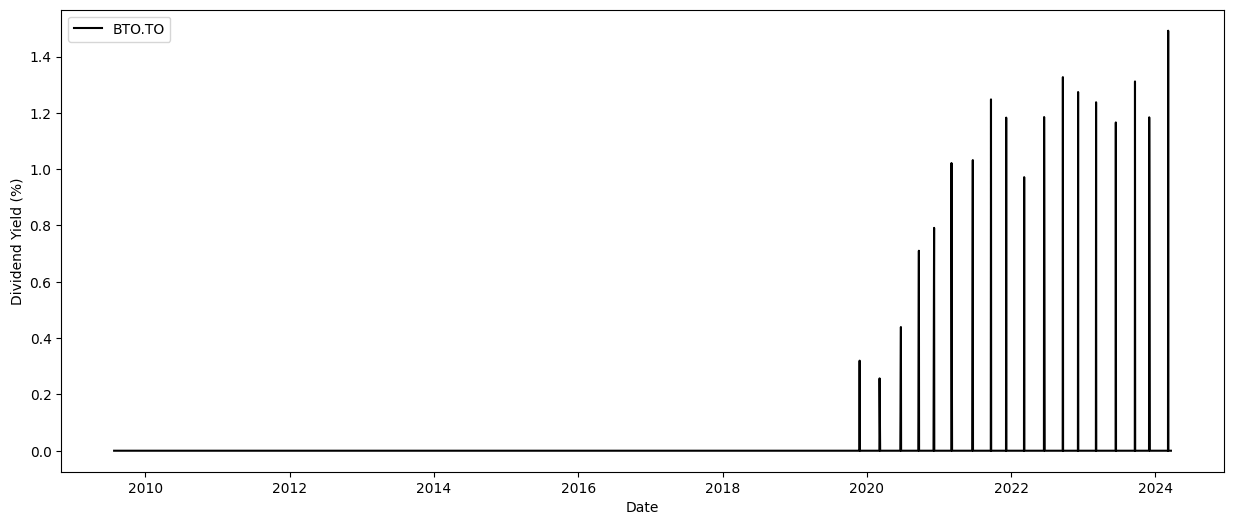

In [37]:
# get share prices and dividend yield data
ticker_all_price = utils.get_historical_share_dividend(share_name, merged_nat_curr)

currency_rate    0.454074
share_price      1.000000
Name: share_price, dtype: float64


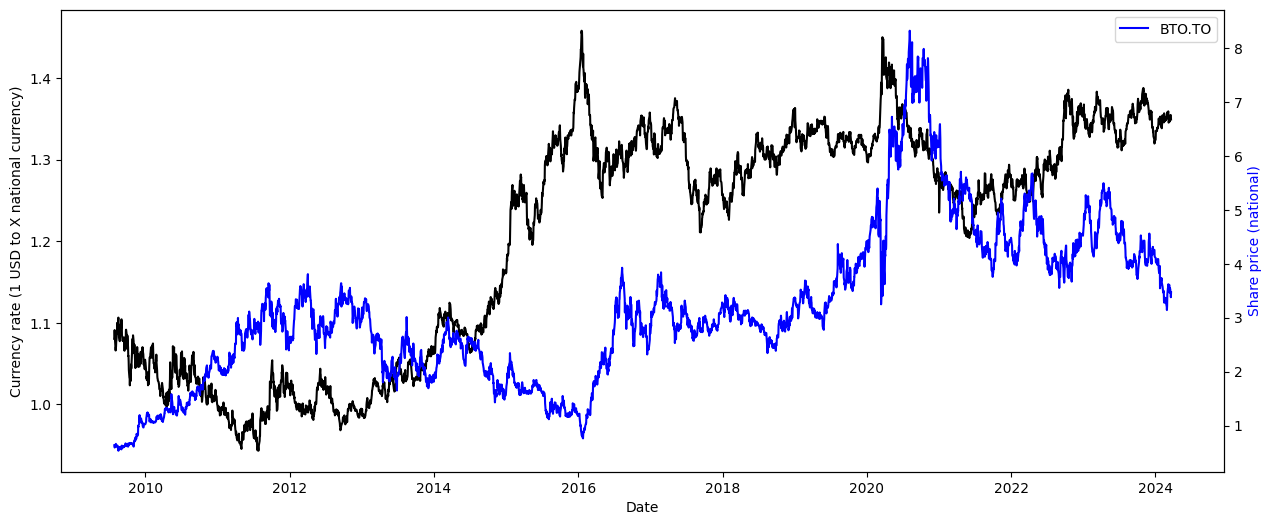

In [38]:
# Pearson's correlation coefficient between share price and USD - national currency rate
utils.get_currency_share_price_correlation(share_name, usd_nat_curr, ticker_all_price)

# Share price and value ratios

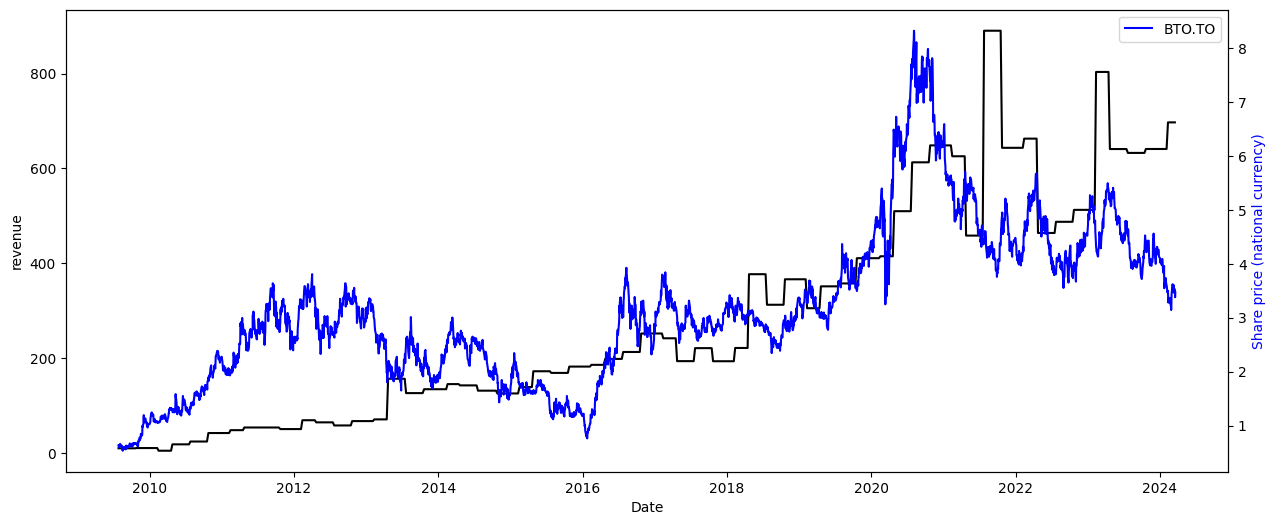

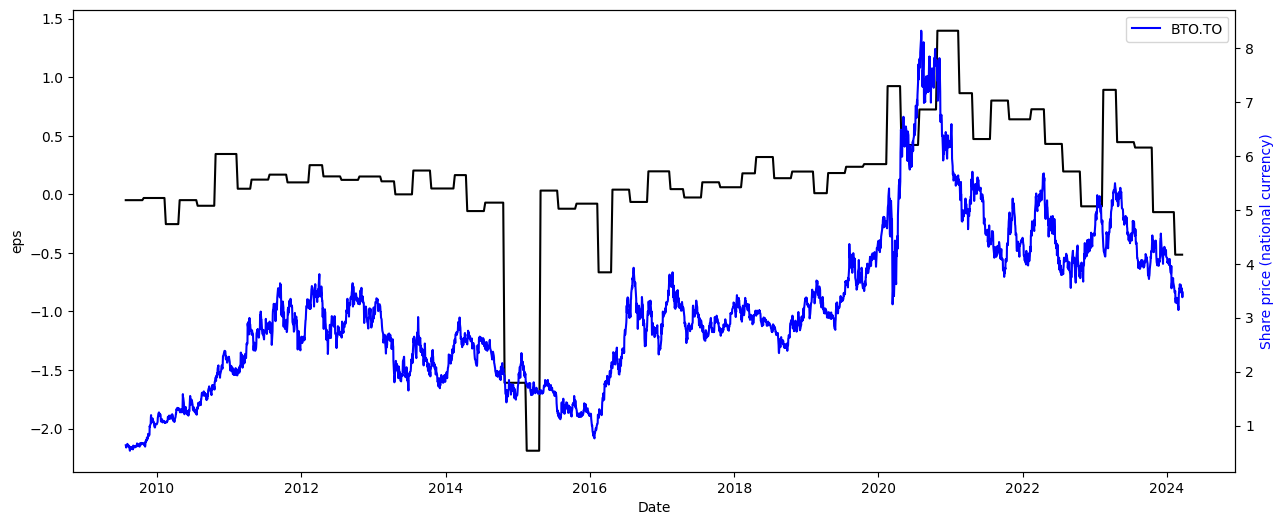

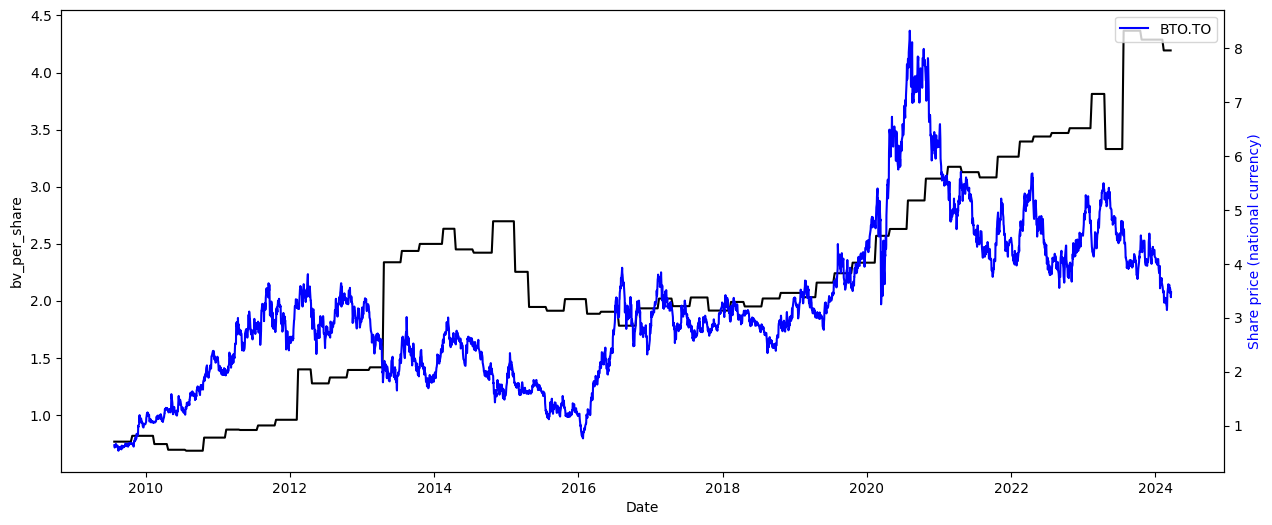

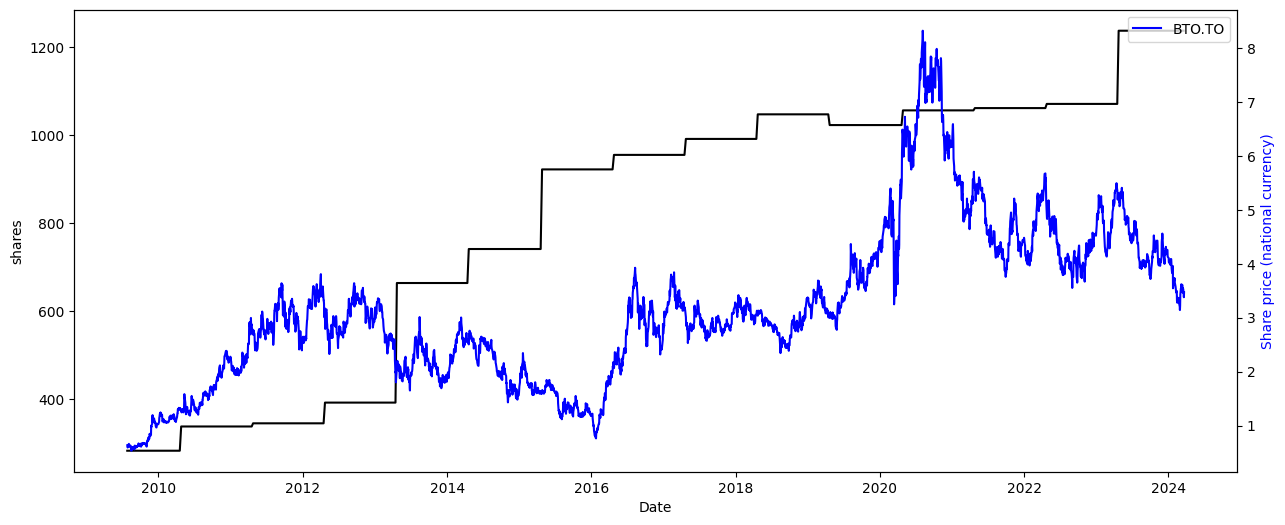

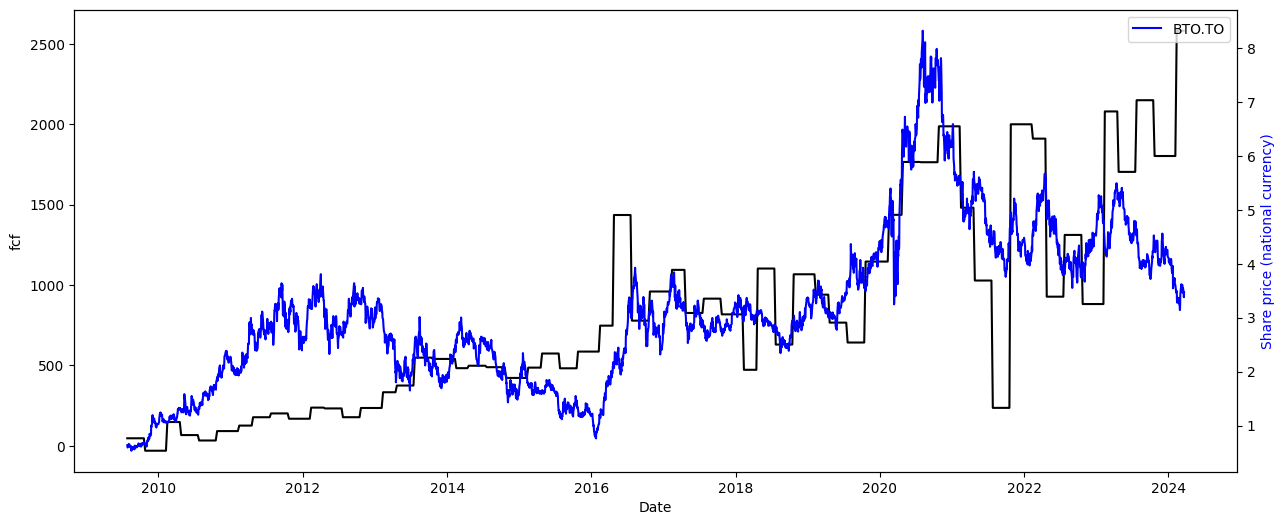

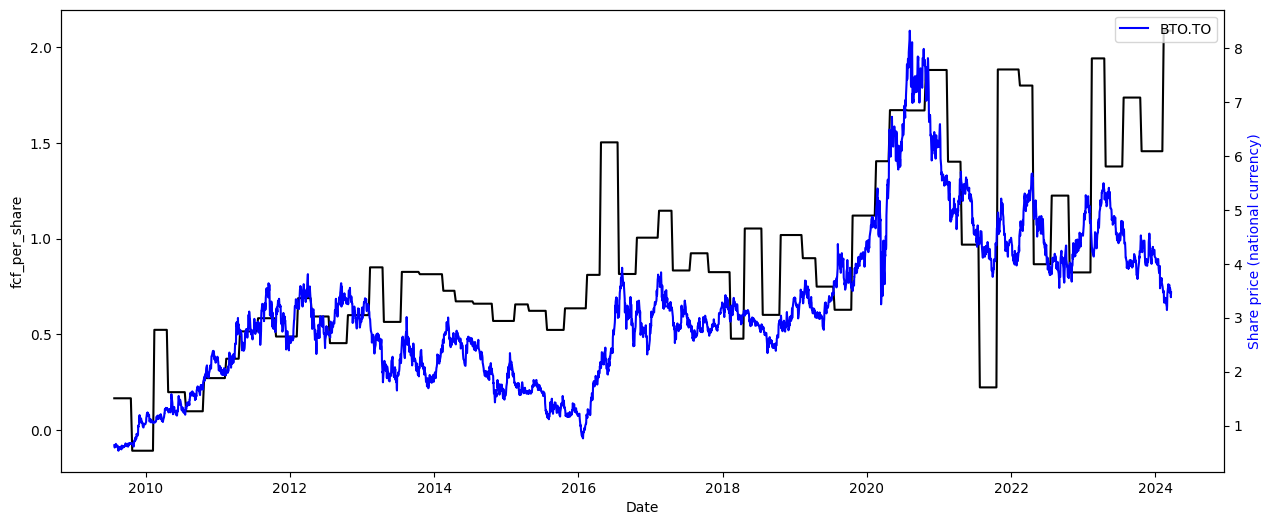

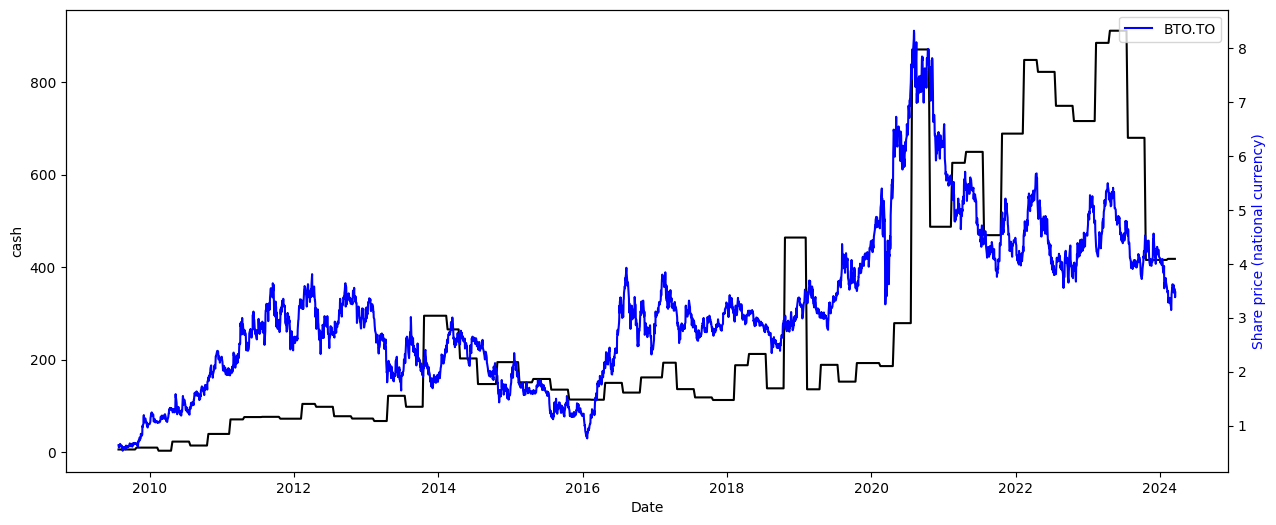

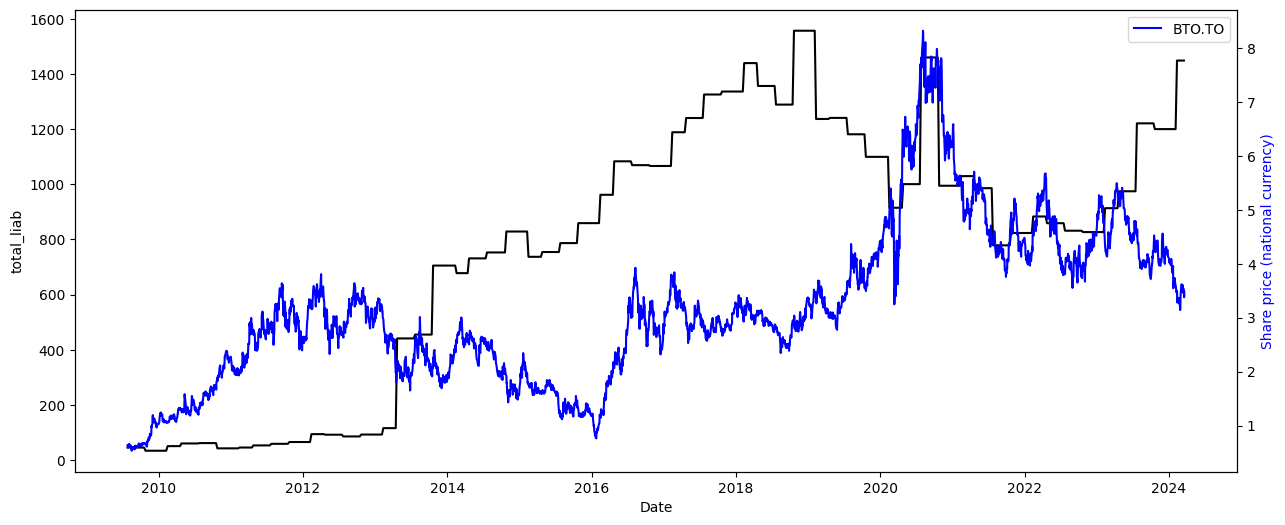

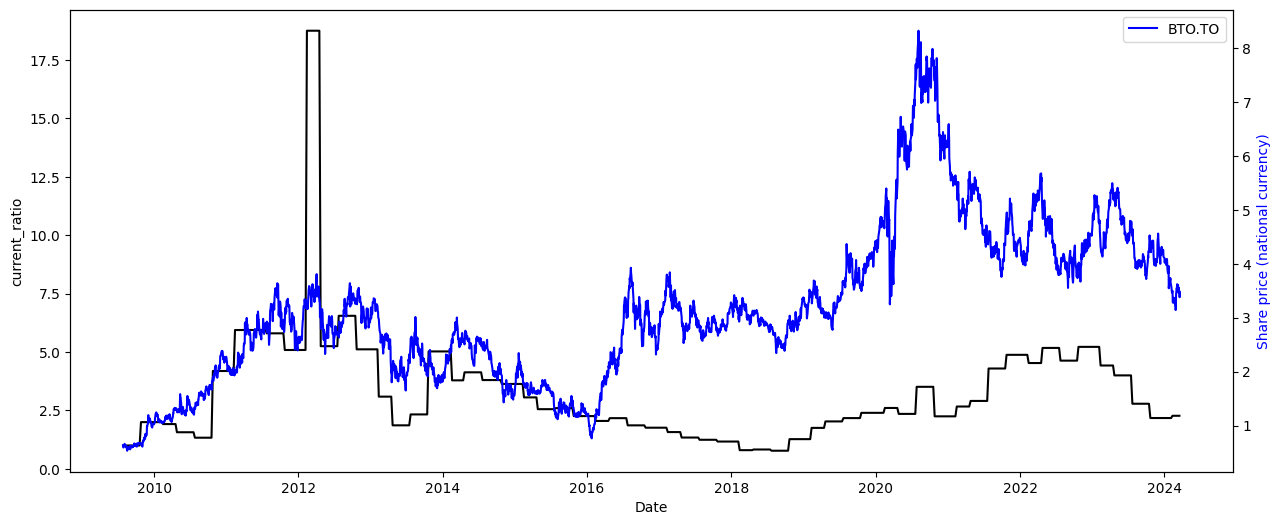

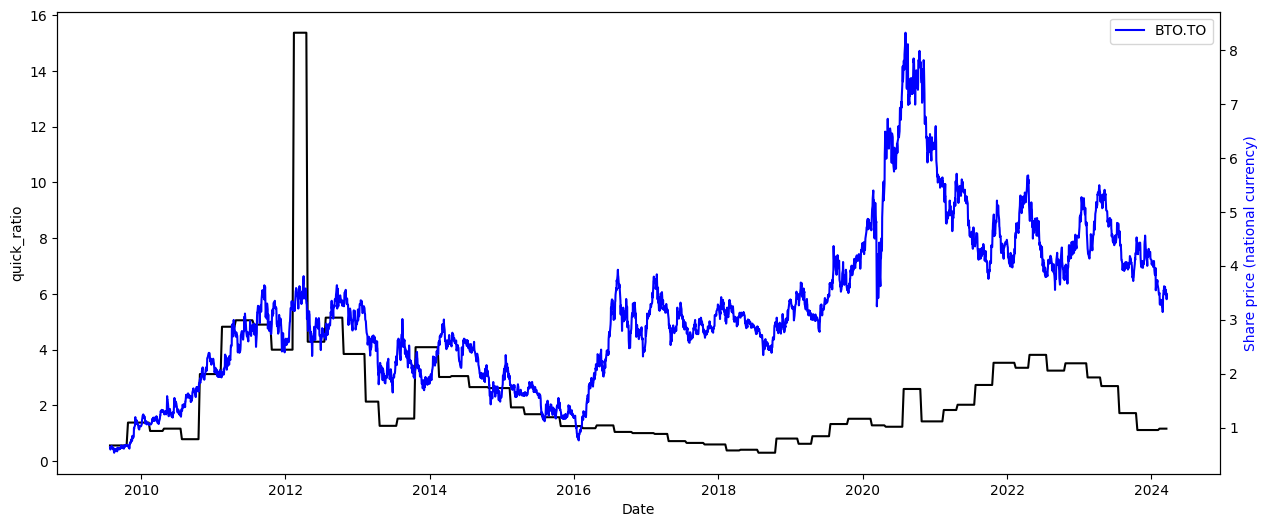

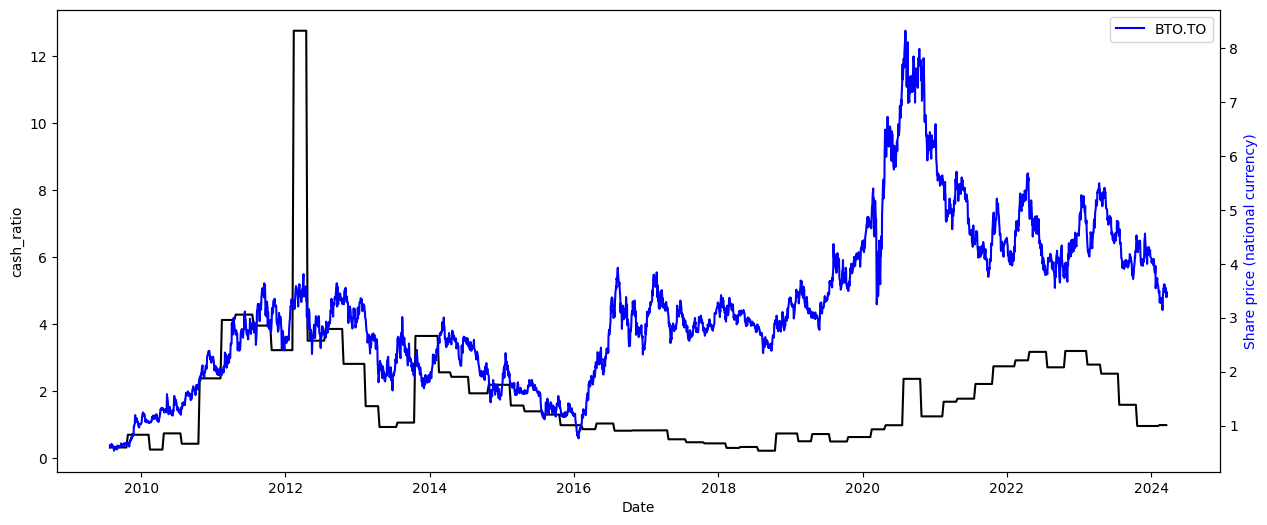

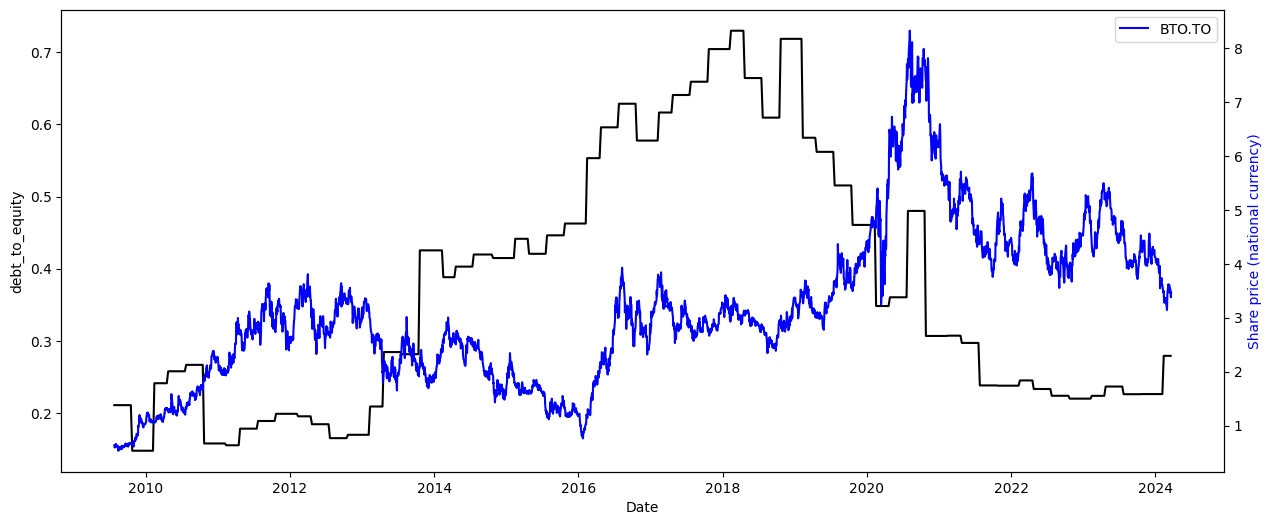

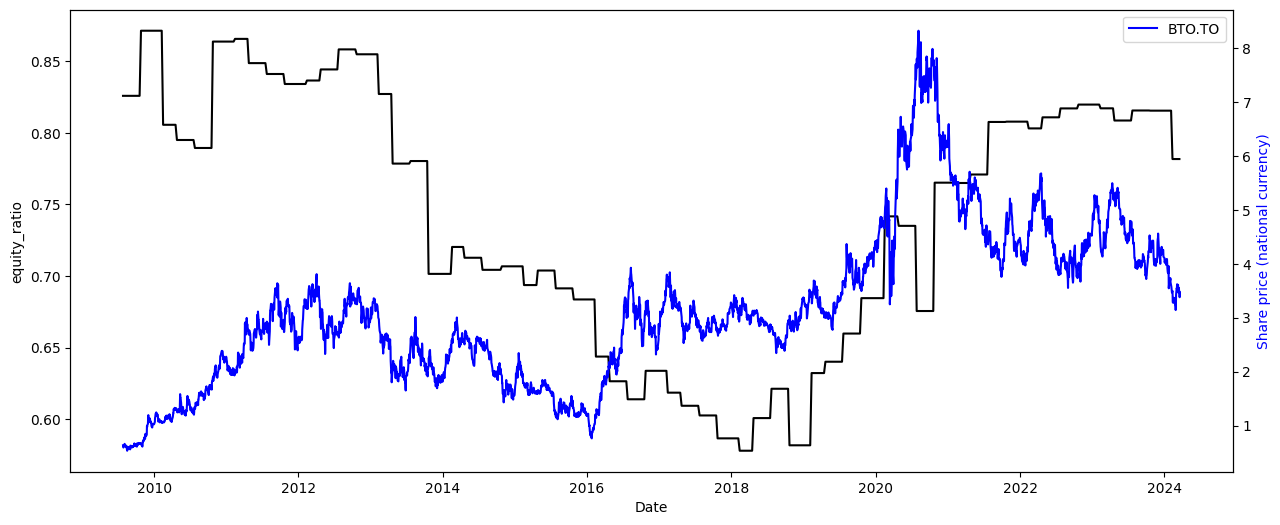

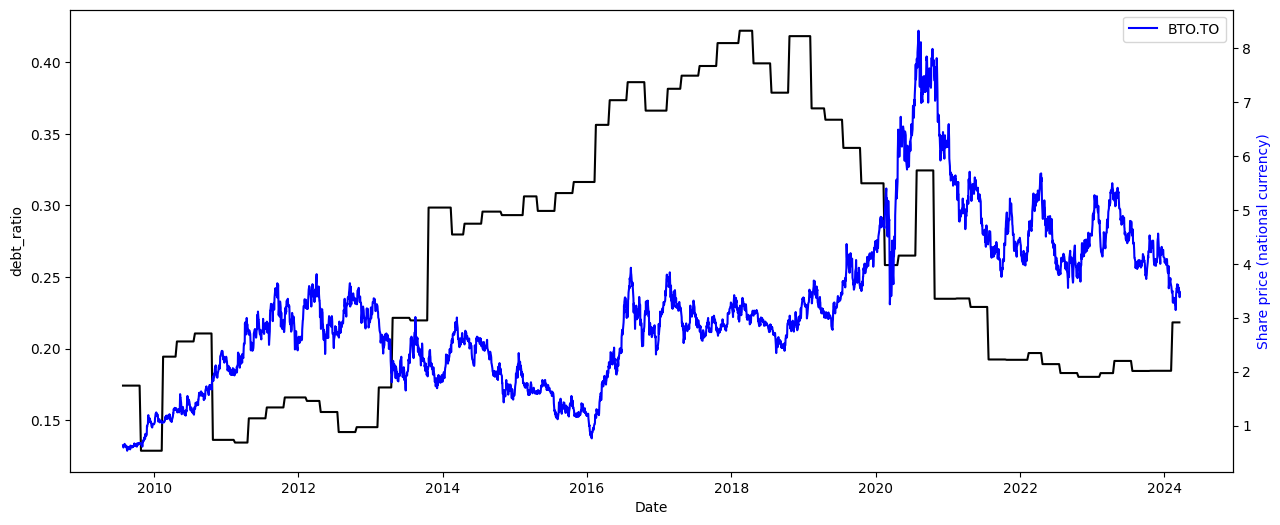

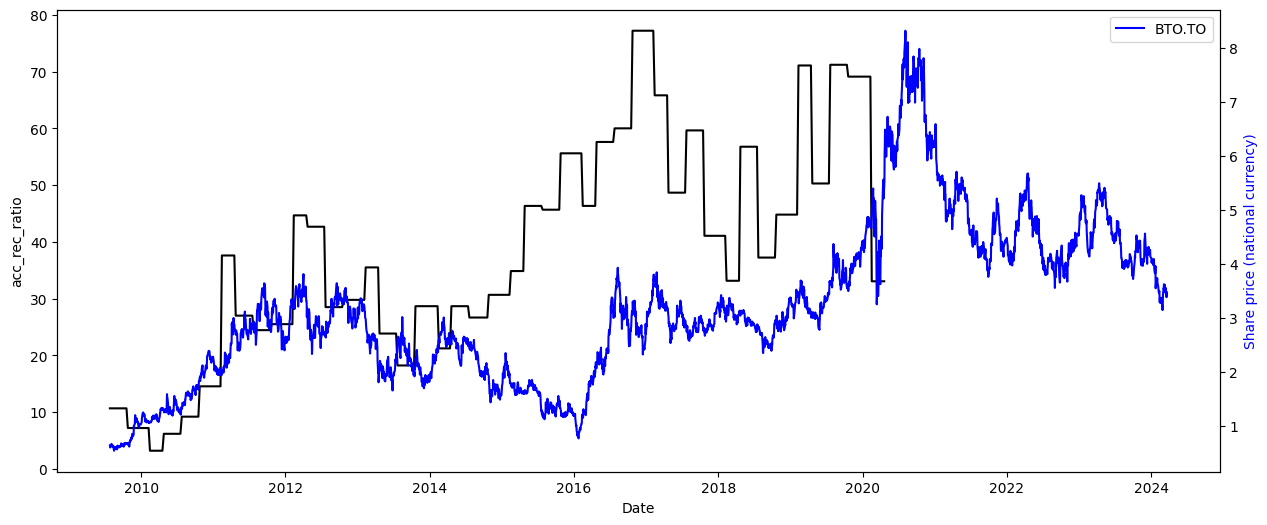

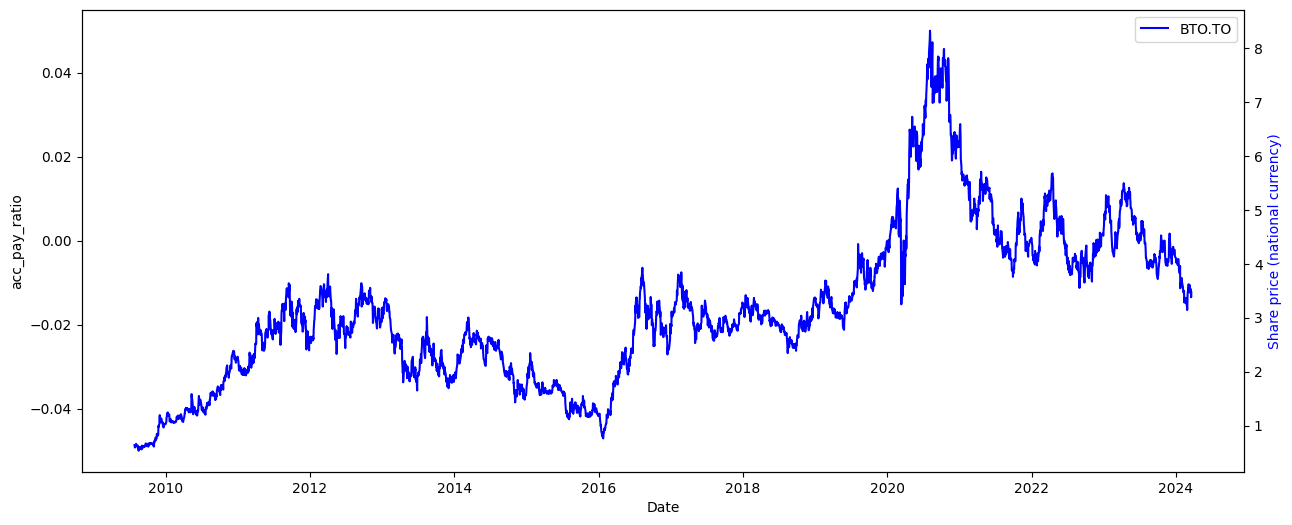

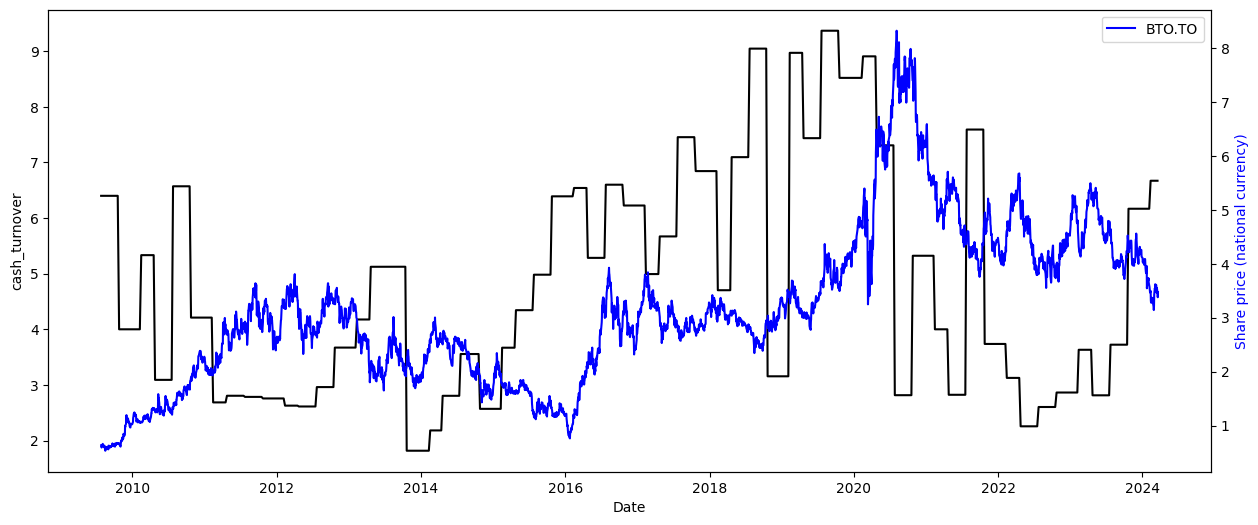

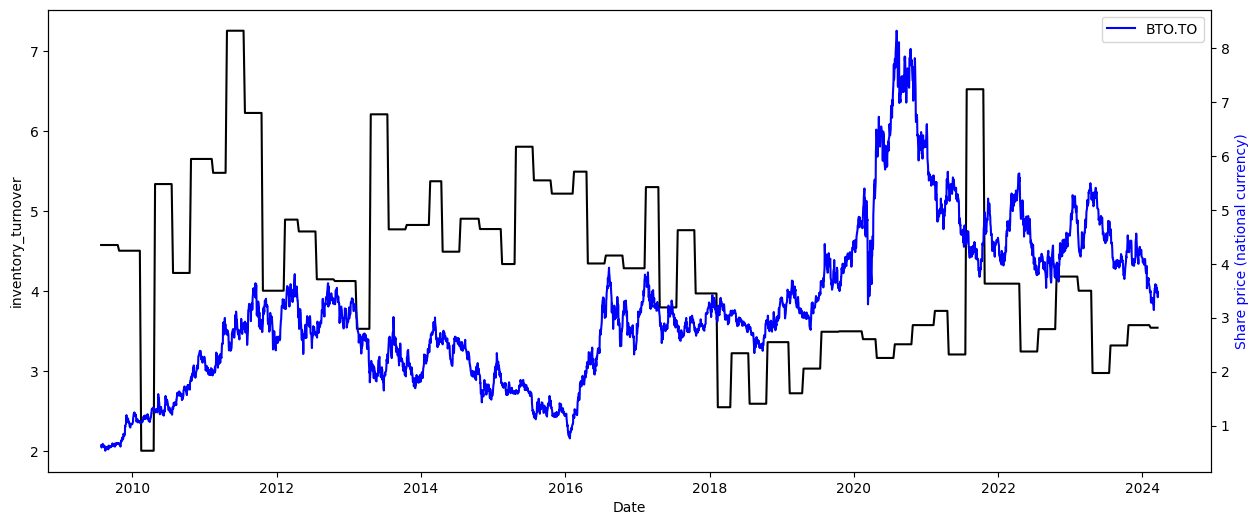

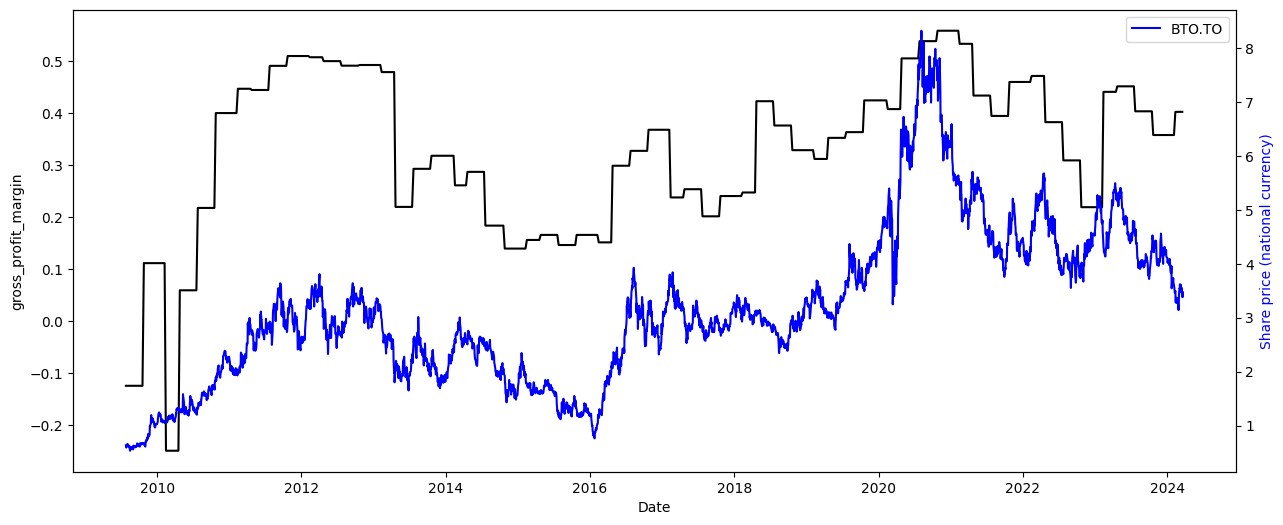

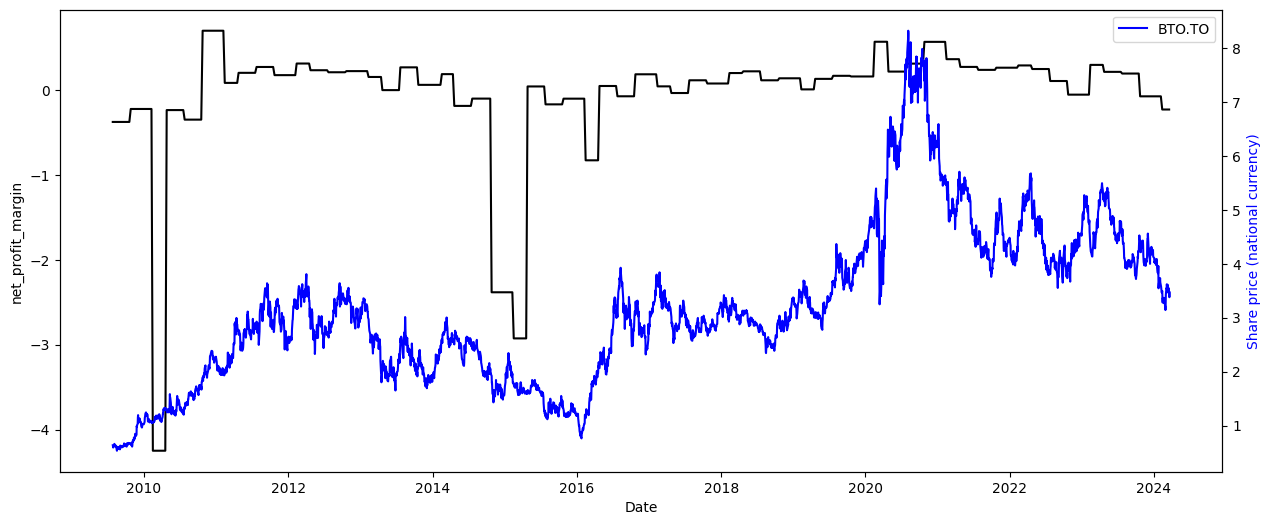

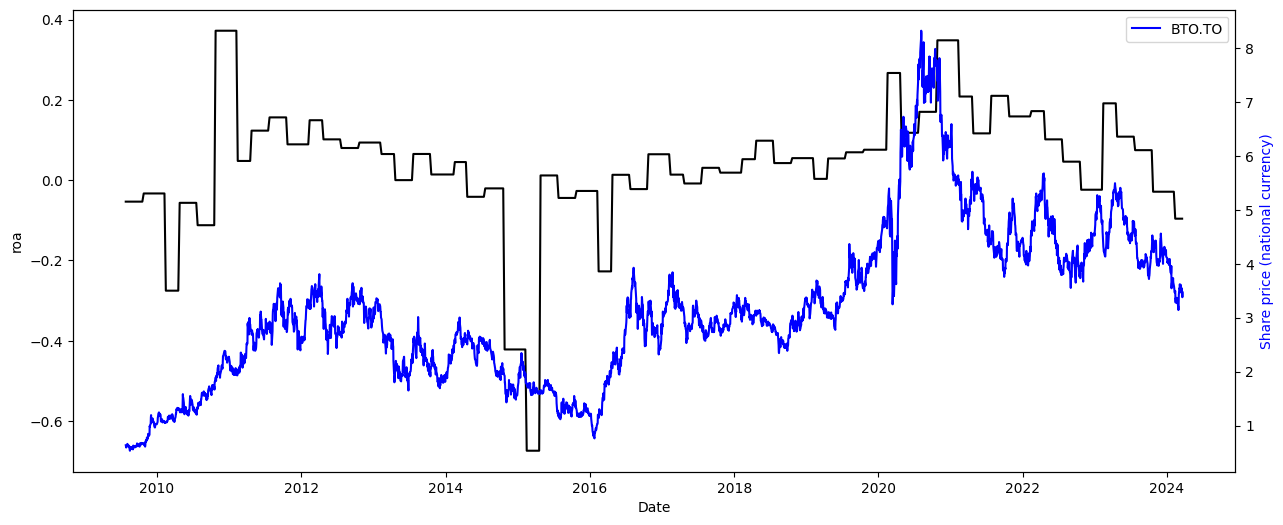

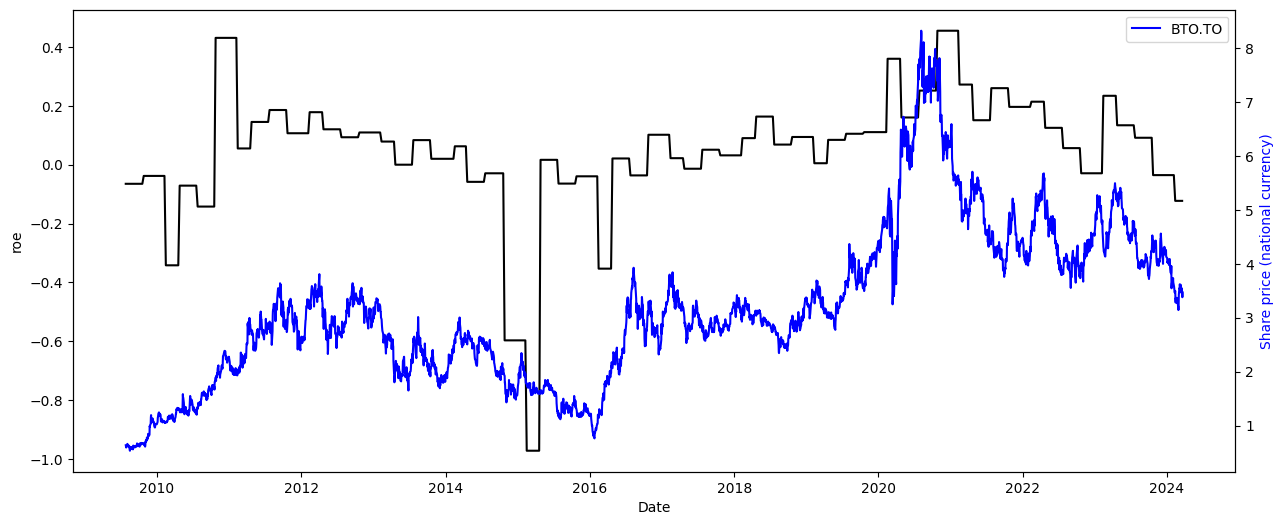

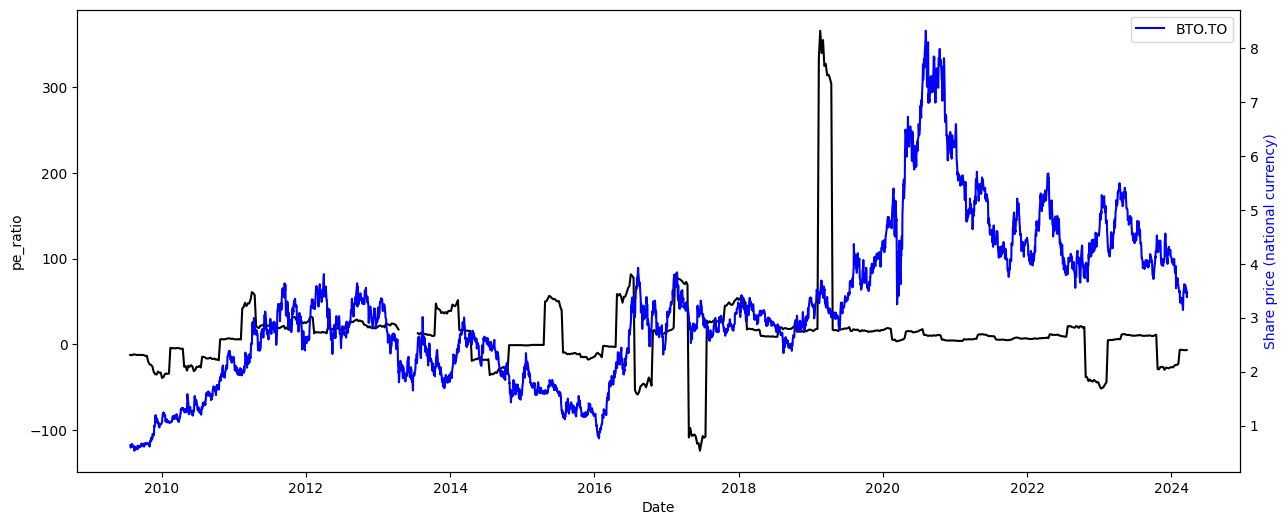

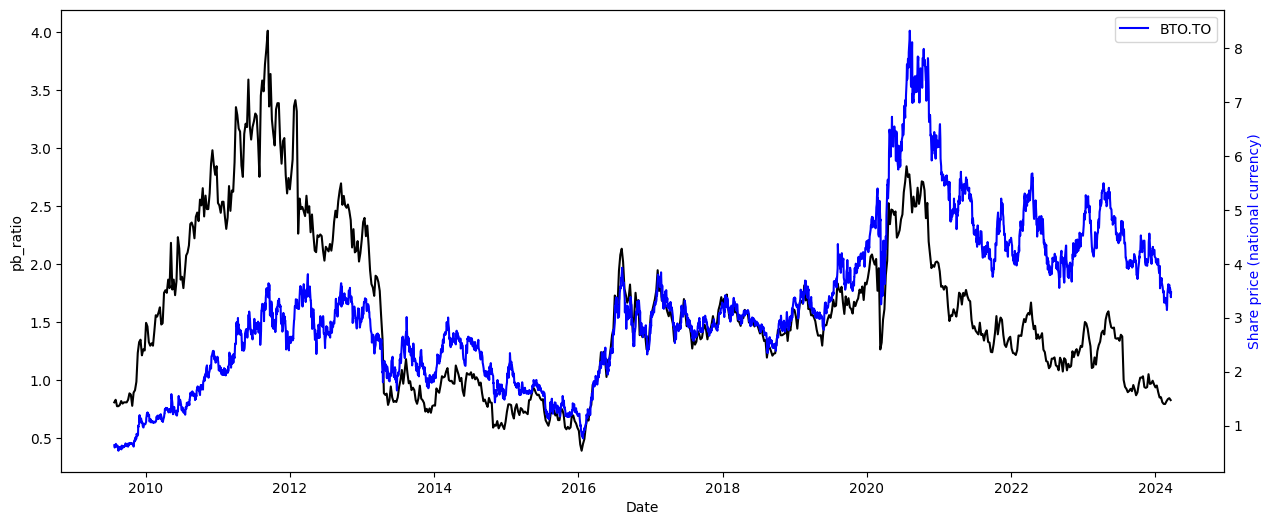

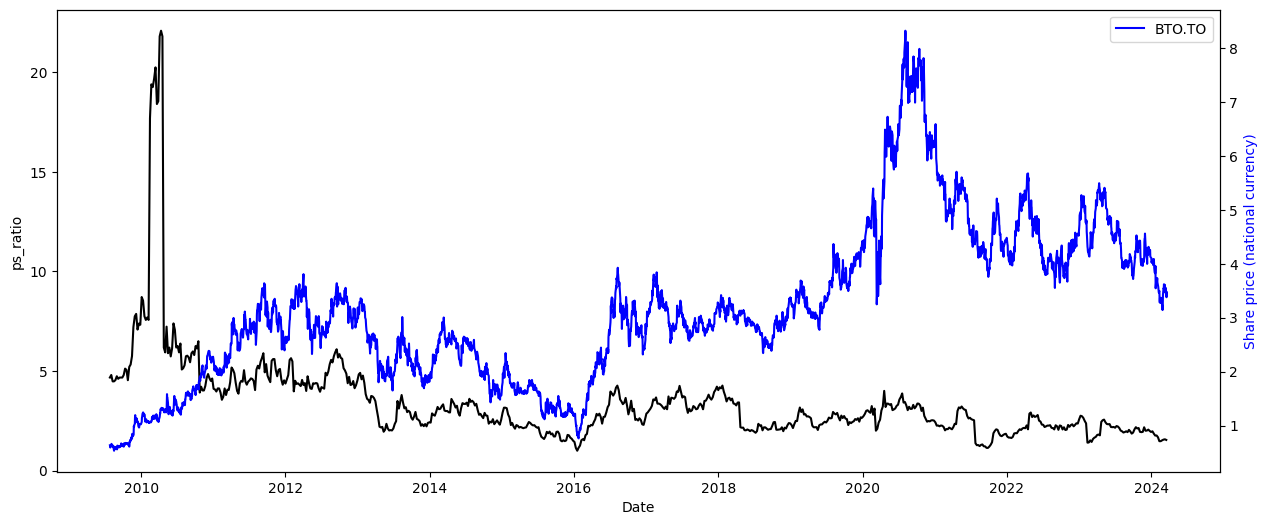

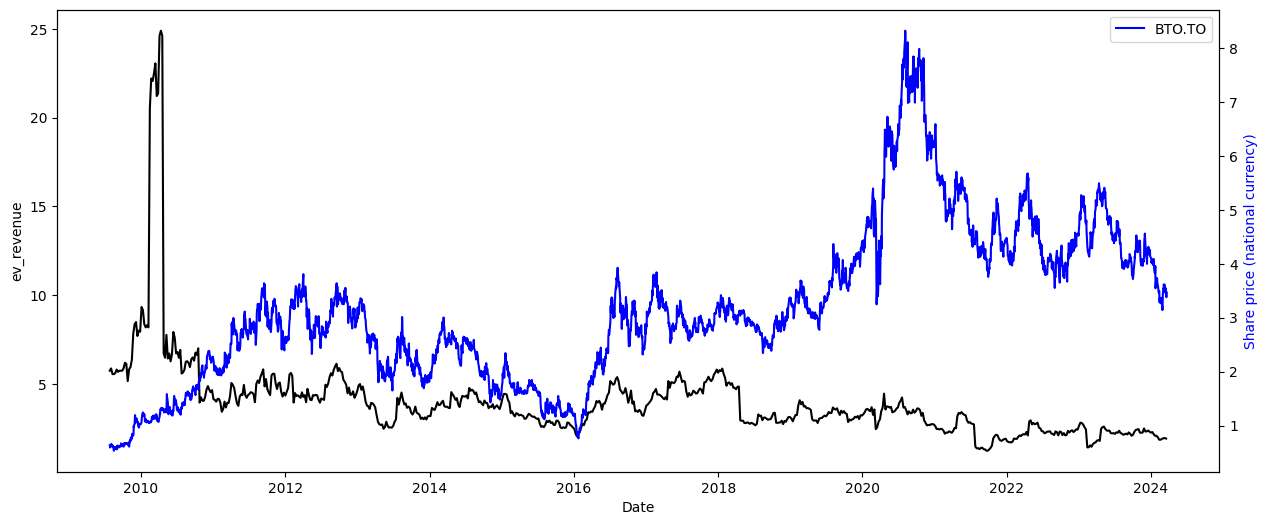

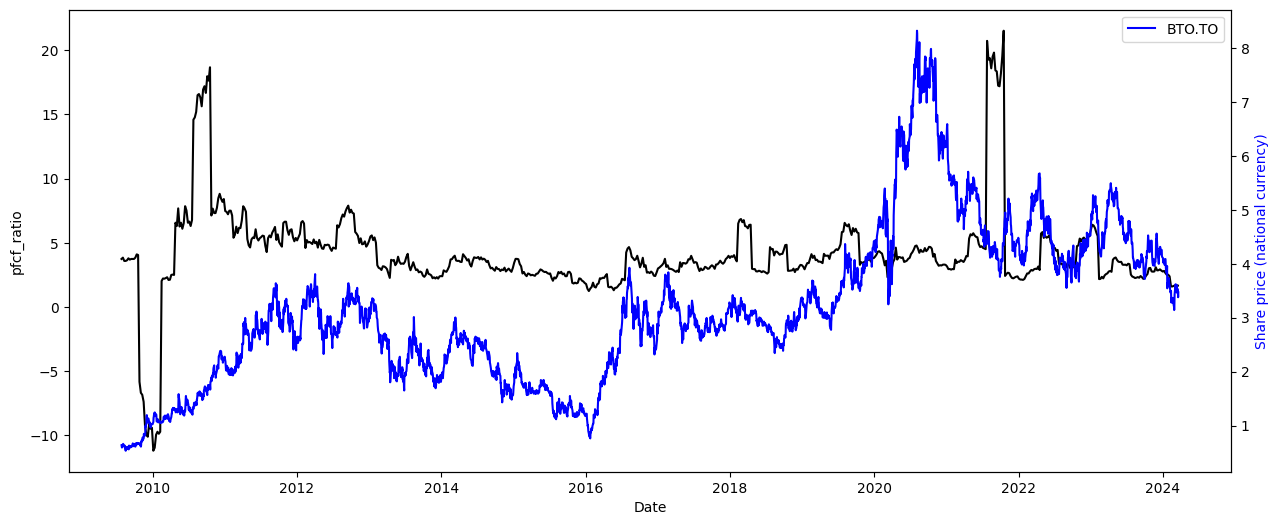

In [39]:
for column in merged_nat_curr.columns[3:]:
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax2 = ax1.twinx()
    ax1.plot(merged_nat_curr['real_date'], merged_nat_curr[column], color='k', label=merged_nat_curr)
    ax2.plot(ticker_all_price.index, ticker_all_price['Close'], color='b', label=share_name)

    ax1.set_xlabel('Date')
    ax1.set_ylabel(column, color='k')
    ax2.set_ylabel('Share price (national currency)', color='b')

    plt.legend()
    plt.show()

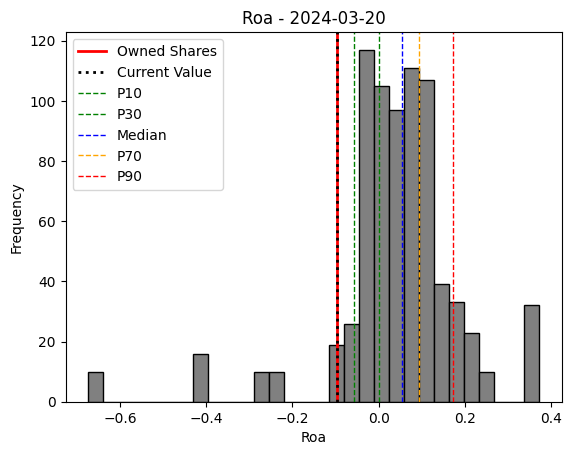

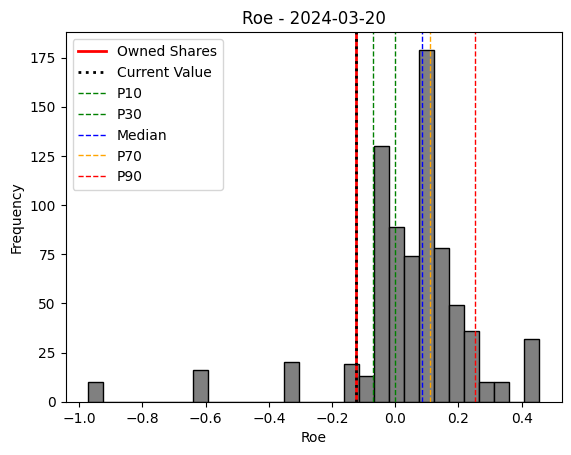

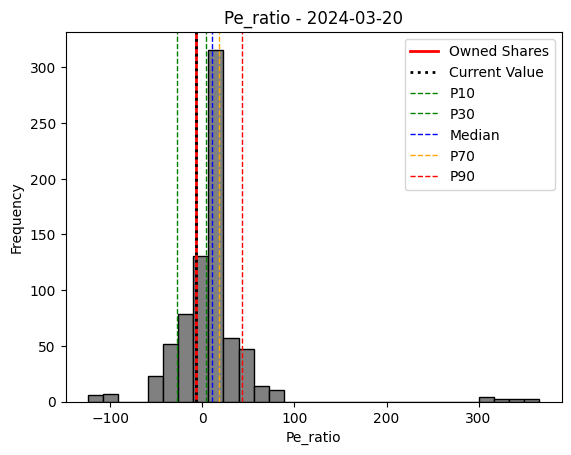

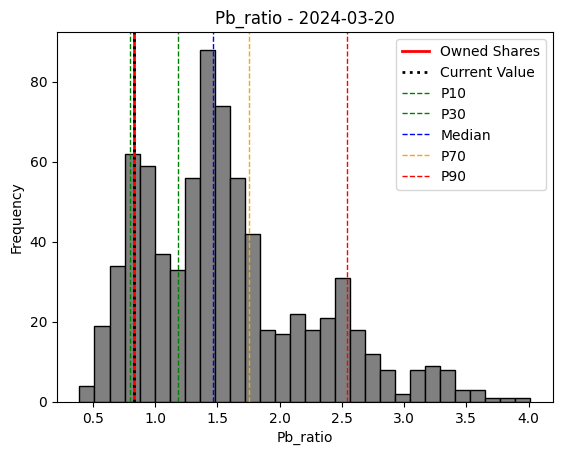

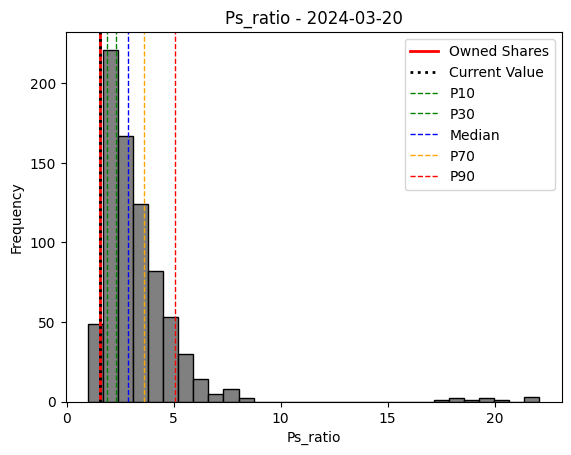

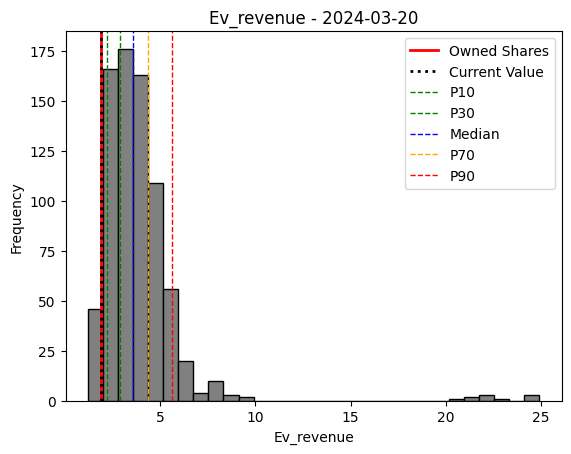

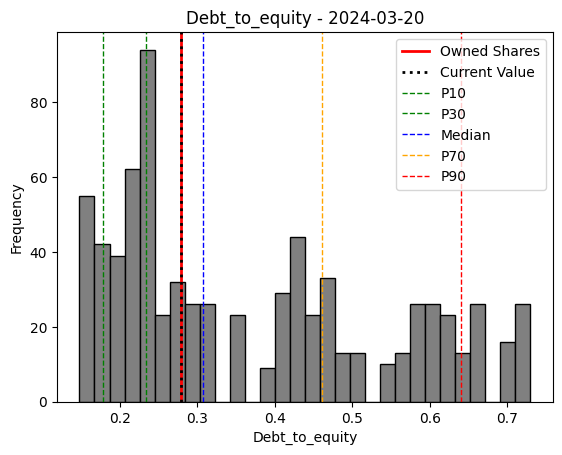

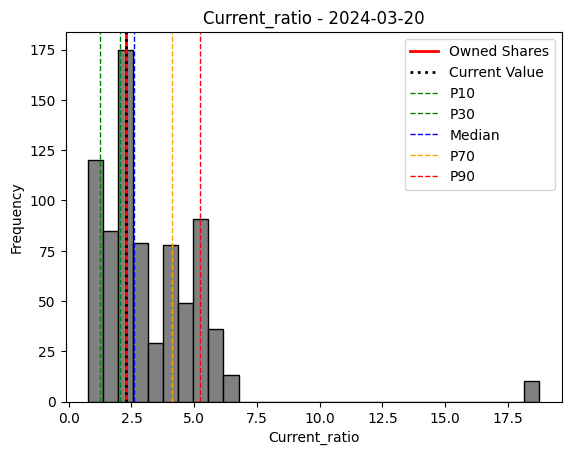

In [40]:
# plot histograms of value parameters
utils.plot_histogram_value_parameters(input_df=merged_nat_curr, extra_parameters=[], owned_shares=owned_shares)

## Calculate correlation between value parameters

In [41]:
# calulate value parameters Pearson's correlation coefficient
pd.DataFrame(merged_nat_curr, columns=['roa', 'roe', 'pe_ratio', 'pb_ratio', 'ps_ratio', 'ev_revenue', 'debt_to_equity', 'current_ratio']).corr()

,roa,roe,pe_ratio,pb_ratio,ps_ratio,ev_revenue,debt_to_equity,current_ratio
roa,1.000000,0.996026,0.104518,0.459923,-0.190861,-0.294083,-0.206173,0.198797
roe,0.996026,1.000000,0.107105,0.444646,-0.176430,-0.273282,-0.165798,0.161043
pe_ratio,0.104518,0.107105,1.000000,0.134469,-0.068265,-0.066651,0.154119,0.017956
pb_ratio,0.459923,0.444646,0.134469,1.000000,0.332107,0.204235,-0.273008,0.340741
ps_ratio,-0.190861,-0.176430,-0.068265,0.332107,1.000000,0.979742,-0.242005,0.027102
ev_revenue,-0.294083,-0.273282,-0.066651,0.204235,0.979742,1.000000,-0.077287,-0.085355
debt_to_equity,-0.206173,-0.165798,0.154119,-0.273008,-0.242005,-0.077287,1.000000,-0.508353
current_ratio,0.198797,0.161043,0.017956,0.340741,0.027102,-0.085355,-0.508353,1.000000


0 timestemos have been found!


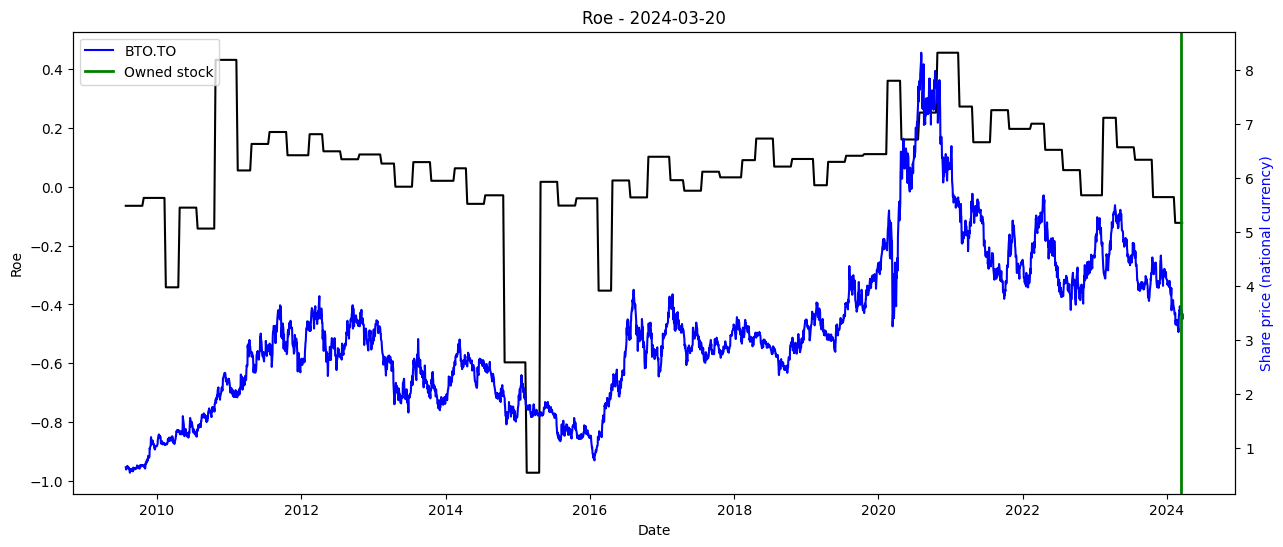

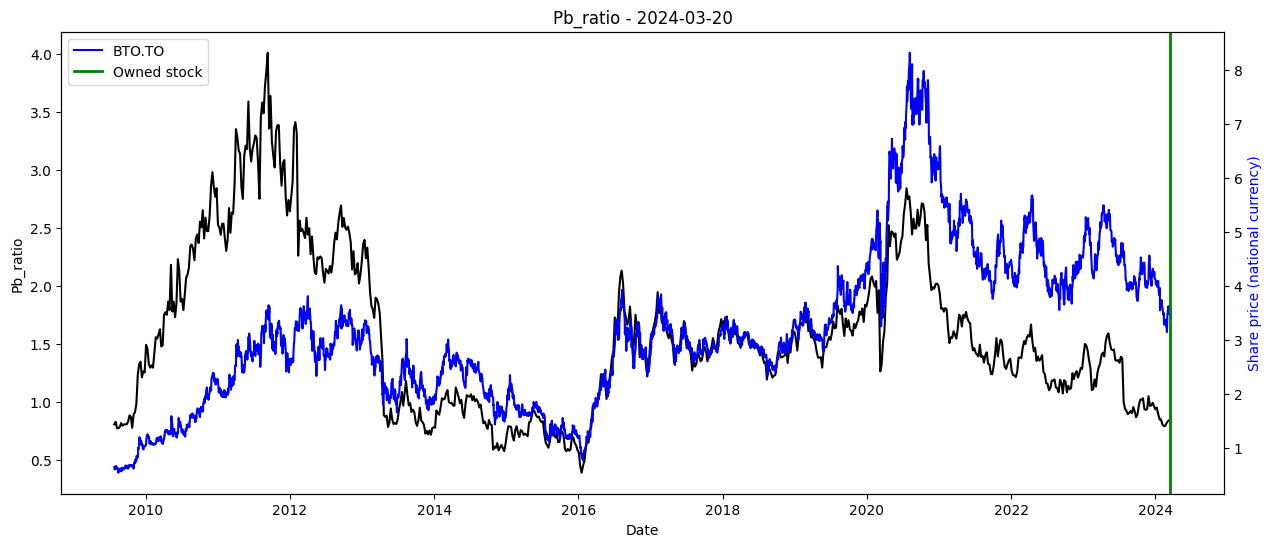

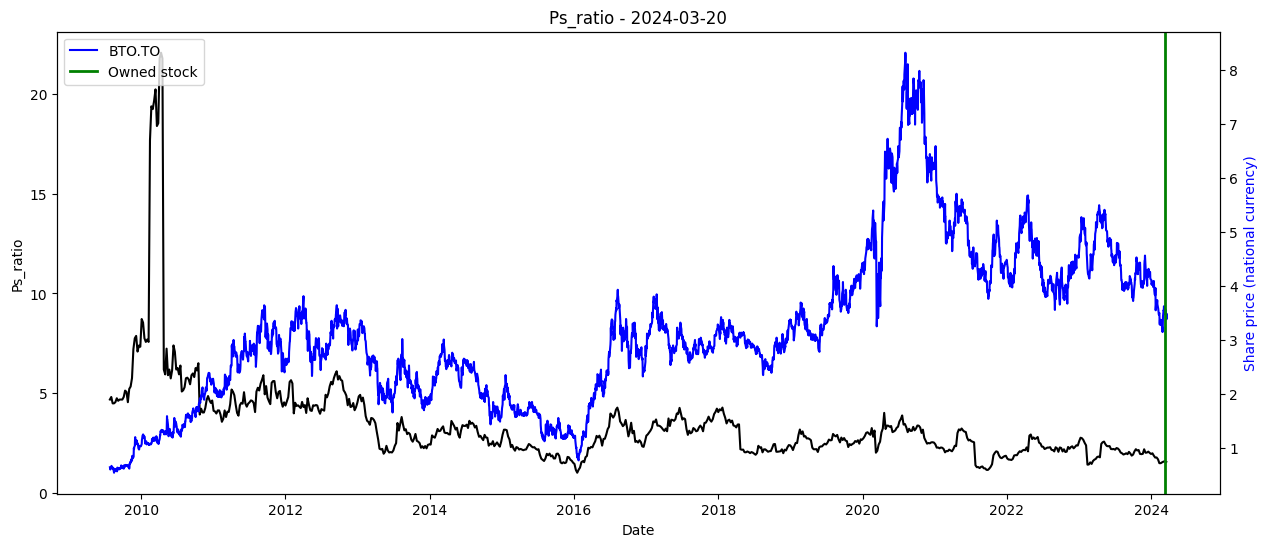

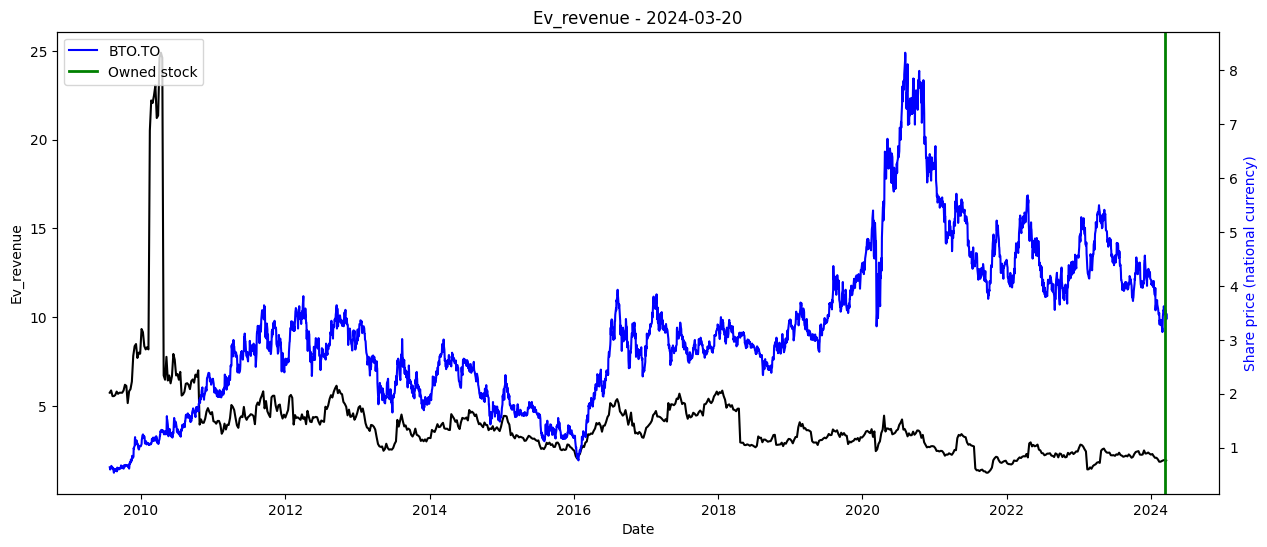

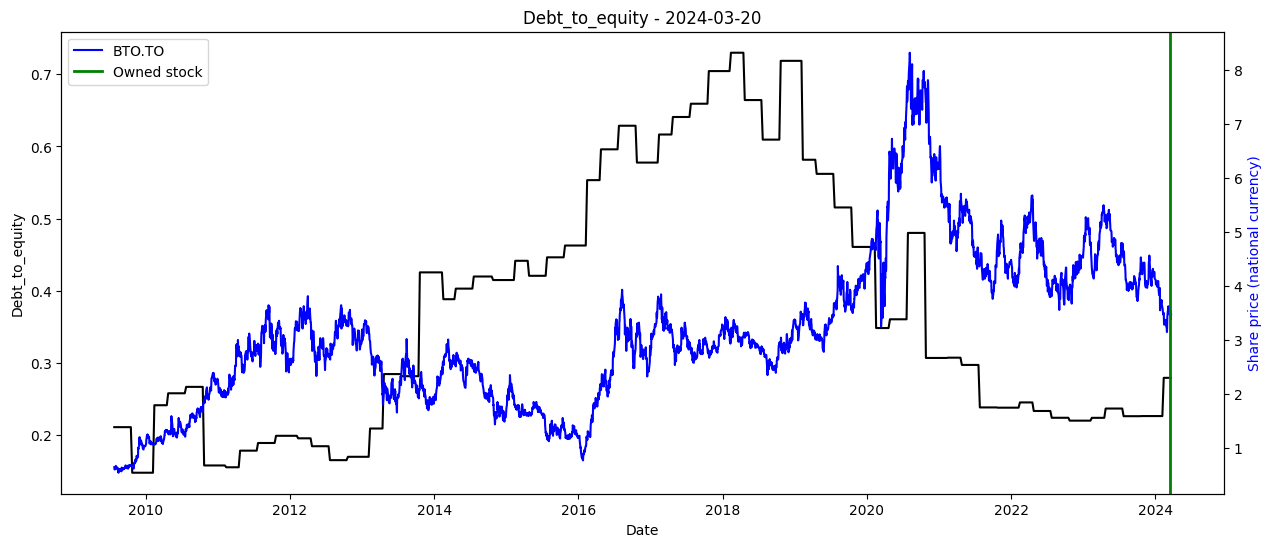

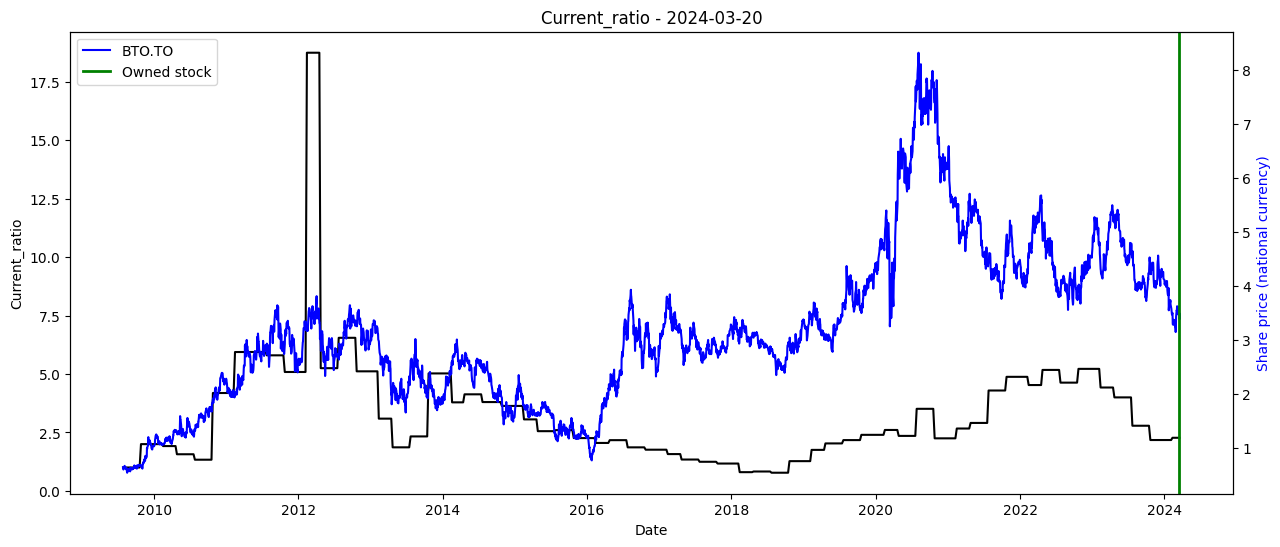

In [42]:
# plot value parameters in time and identify similar events
utils.get_historical_analouges(
    input_df=merged_nat_curr,
    ticker_all_price=ticker_all_price,
    share_name=share_name,
    tolerance=0.2,
    owned_shares=owned_shares
    )